In [ ]:
!pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.3 MB/s eta 0:00:00


In [ ]:
import pickle
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import seaborn as sns

from os.path import join
from loguru import logger
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import classification_report
import pandas as pd

In [ ]:
!pip install -q kaggle

clear_output()

In [ ]:
from google.colab import files
files.upload()

clear_output()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [01:33<00:00, 124MB/s]
100% 9.51G/9.51G [01:33<00:00, 109MB/s]


In [ ]:
!unzip aptos2019-blindness-detection.zip

clear_output()

In [ ]:
RESCALE_SIZE = 224, 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

print(f"Using device: {DEVICE}")

Using device: cpu


## Создаем датасет данных
Обязательно структура файла train и test. Задает исходно с какими файлами мы работаем

Задачи:
1. Подстроить класс под нашу структуру папок
2. Определить значения нормализации

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


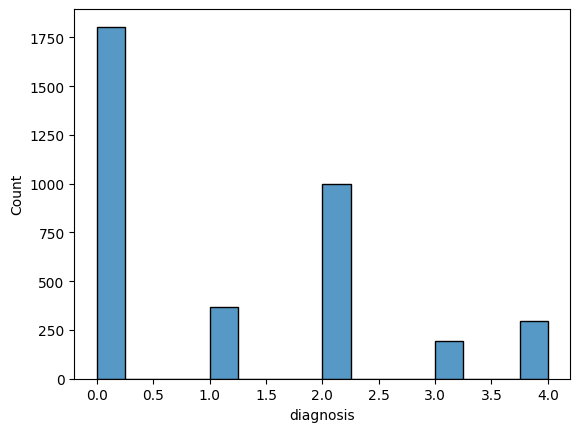

In [ ]:
sns.histplot(train['diagnosis']);

**Классы, очевидно, не сбалансированы между собой**

In [ ]:
class OcularDataset(Dataset):
    def __init__(self, files, mode="train") -> None:
        super().__init__()
        # Сортируем файлы, чтобы они всегда были в одном
        # и том же порядке
        self.files = sorted(list(files))
        # Записываем количество
        self.len_ = len(self.files)
        # Классы переводим в числа
        self.label_encoder = LabelEncoder()
        # Train vs test
        self.mode = mode

        # Берем id и находим соответствие в таблице
        self.labels = []
        for path in files:
          id_code = path.parts[-1].split('.png')[0]
          label = train.loc[train.id_code == id_code, 'diagnosis'].array[0]
          self.labels.append(label)
        # Фитим label encoder на числах
        self.label_encoder.fit(self.labels)

        # Сохраняем label encoder в отдельный файл
        # Чтобы он всегда был одинаковый
        if self.mode == "train":
            with open("label_encoder.pkl", "wb") as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
      """
      Загружаем картинки из файлов
      """
      image = Image.open(file)
      image.load()
      return image

    def __getitem__(self, index):
      """
      По индексу достаем картинку и лэйбл
      """
        # Лучше перенести в init
      if self.mode == "train":
        transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.RandomRotation(degrees=180),
                        # ADDITIONAL AUGMENTATIONS
                        transforms.ToTensor(),
                        # Посчитала mean и sd по рекоменадции Влада
                        transforms.Normalize([0.4064, 0.2169, 0.0722], [0.2786, 0.1515, 0.0811])
                        ])

      else:
        transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        # Аналогичная нормализация
                        transforms.Normalize([0.4064, 0.2169, 0.0722], [0.2786, 0.1515, 0.0811])
                        ])
      # загружаем картинку
      x = self.load_sample(self.files[index])
      x = transform(x)
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()

      return x, y

## Класс для тренировки и валидации моделей

In [ ]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()

        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [ ]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)

    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score

    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

## Собираем наши данные

In [ ]:
train_val_files = sorted(list(Path('train_images').rglob("*.png")))

train_val_labels = []
for path in train_val_files:
  id_code = path.parts[-1].split('.png')[0]
  #if id_code.endswith(')'):
  #  print(id_code)
  #  continue
  label = train.loc[train.id_code == id_code, 'diagnosis'].array[0]
  train_val_labels.append(label)

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
N_CLASSES = len(set(train_val_labels))
N_CLASSES

5

## Собираем датасеты и даталоэдеры

Так как классы не сбалансированы, присваиваем веса.

In [ ]:
#from collections import Counter
#from torch.utils.data.sampler import WeightedRandomSampler


#class_numbers = Counter(train_val_labels)
#samples_weight = torch.tensor([1 / class_numbers[i] for i in train_val_labels])

In [ ]:
class_numbers

Counter({2: 999, 4: 296, 1: 370, 0: 1816, 3: 193})

In [ ]:
len(samples_weight)

3674

In [ ]:
len(train_val_labels)

3674

In [ ]:
trainset = OcularDataset(train_files)
valset = OcularDataset(val_files, mode="val")

# Пока веса не получилось применить, выдается ошибка на индексах
#sampler = WeightedRandomSampler(samples_weight.type("torch.DoubleTensor"), len(samples_weight))

# Нельзя использовать shuffle вместе с sampler
# WeightedRandomSampler кажется и так рандомно отбирает данные, поэтому shuffle не нужен
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE)
valloader = DataLoader(valset, batch_size=BATCH_SIZE)

Считаю среднее и стандартное отклонение по всему датасету для исходной нормализации

In [ ]:
#sum = 0
#sum_squared = 0
#num = 0

#for batch, _ in trainloader:
#    sum += torch.mean(batch, dim=[0,2,3])
#    sum_squared += torch.mean(batch**2, dim=[0,2,3])
#    num += 1

#mean = sum / num
#mean_squared = sum_squared / num
#sigma = (mean_squared - mean ** 2) ** 0.5

#print(mean, sigma)

tensor([0.4064, 0.2169, 0.0722]) tensor([0.2786, 0.1515, 0.0811])


## Тренирую разные модели

### VGG19 без учета баланса классов

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Попробую ничего не менять в модели и только вывод оставить в 5 классов

In [ ]:
num_features = 25088
model.classifier = nn.Linear(num_features, N_CLASSES)

In [ ]:
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 87 out of 87
Validation: batch 29 out of 29

Epoch 1 out of 10: Train loss = 1.351179697047705, validation loss = 1.3270901153827537 
                                         Train metric = 0.22540834845735028, validation metric = 0.20565832426550598

Training: batch 87 out of 87
Validation: batch 29 out of 29

Epoch 2 out of 10: Train loss = 1.3123582039756336, validation loss = 1.3202358854228053 
                                         Train metric = 0.2823956442831216, validation metric = 0.2513601741022851

Training: batch 87 out of 87
Validation: batch 29 out of 29

Epoch 3 out of 10: Train loss = 1.3009646075895462, validation loss = 1.3409249330389088 
                                         Train metric = 0.2588021778584392, validation metric = 0.2916213275299238

Training: batch 87 out of 87
Validation: batch 29 out of 29

Epoch 4 out of 10: Train loss = 1.3042486878647201, validation loss = 1.3085288056011857 
                                         Train 

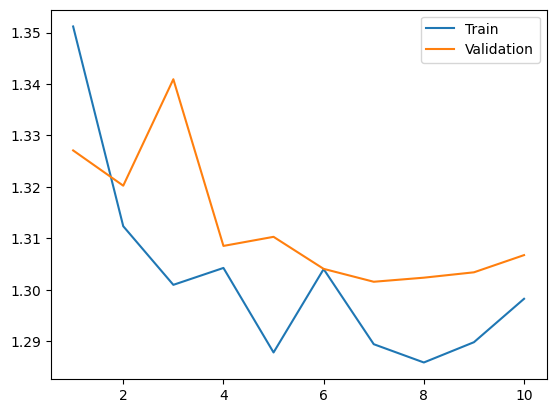

In [ ]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [ ]:
calculate_metric(model, valloader)

0.4940152339499456

In [ ]:
from functools import partial

f1_macro = partial(f1_score, average="macro")
f1_micro = partial(f1_score, average="micro")

In [ ]:
calculate_metric(model, valloader, f1_macro)  # Именно он учитывает предсказание мало представленных классов

0.13226511289147852

In [ ]:
calculate_metric(model, valloader, f1_micro)

0.4940152339499456

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/models/"

In [ ]:
torch.save(model.state_dict(), os.path.join(MODEL_PATH, '1_vgg19_bs42_nonstableclass.pt'))

**Важно**

В этом варианте не заметила, что работала с дубликатами фоток. Поэтому не везде лэйблы реально совпадали со значениями (видать, была ошибка при загрузке на гугл диск). Дальше все исправила

### VGG19 с учетом баланса классов

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Нужно просто сделать отдельный sampler для trainset и для valset, так как в них у нас сохранены корректные лэйблы

In [ ]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

In [ ]:
trainset = OcularDataset(train_files)
valset = OcularDataset(val_files, mode="val")

In [ ]:
class_numbers_train = Counter(trainset.labels)
samples_weight_train = torch.tensor([1 / class_numbers_train[i] for i in trainset.labels])

class_numbers_val =  Counter(valset.labels)
samples_weight_val = torch.tensor([1 / class_numbers_val[i] for i in valset.labels])

sampler_train = WeightedRandomSampler(samples_weight_train.type("torch.DoubleTensor"), len(samples_weight_train))
sampler_val = WeightedRandomSampler(samples_weight_val.type("torch.DoubleTensor"), len(samples_weight_val))

# Нельзя использовать shuffle вместе с sampler
# WeightedRandomSampler кажется и так рандомно отбирает данные, поэтому shuffle не нужен
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=sampler_train)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, sampler=sampler_val)

Изменю только последний слой. Весь классификатор не меняю

In [ ]:
last_layer = nn.Linear(in_features=4096, out_features=5, bias=True)
model.classifier[6] = last_layer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

KeyboardInterrupt: 

Для подсчета перебегаю в другой колаб для cuda

In [ ]:
torch.save(trainloader, 'trainloader.pth')
torch.save(valloader, 'valloader.pth')

In [ ]:
from google.colab import files
files.download('trainloader.pth')
files.download('valloader.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>